In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Install required libraries

In [3]:
# Install required libraries
!pip install torch torchaudio numpy pandas librosa scikit-learn matplotlib seaborn

import numpy as np
import pandas as pd
import librosa
import os
import torch
import torch.nn as nn
import torch.utils.data as data
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.2 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.10.19
    Uninstalling nvidia-curand-cu12-

# Set random seed for reproducibility

In [7]:
# Set random seed for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# Define dataset path
dataset_slug = 'ravdess-speech'
dataset_path = f'/kaggle/input/{dataset_slug}'
data_dirs = [
    f'{dataset_path}/Audio_Speech_Actors_01-24',
    f'{dataset_path}/Audio_Song_Actors_01-24'
]

# Verify paths
print("Dataset path:", dataset_path)
print("Contents:", os.listdir(dataset_path))

Device: cuda
Dataset path: /kaggle/input/ravdess-speech
Contents: ['Audio_Song_Actors_01-24', 'Audio_Speech_Actors_01-24']


# Define emotion mapping (including neutral)

In [9]:
# Define emotion mapping (including neutral)
labels_map = {
    'neutral': 0, 'calm': 1, 'happy': 2, 'sad': 3,
    'angry': 4, 'fearful': 5, 'disgust': 6, 'surprised': 7
}
emotion_names = list(labels_map.keys())

# Define augmentation functions

In [10]:
# Define augmentation functions
def noise(data):
    noise_amp = 0.035 * np.random.uniform() * np.amax(data)
    data = data + noise_amp * np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-2, high=2) * 1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)


# Step 1: Collect file paths and labels (include neutral)

In [11]:
# Step 1: Collect file paths and labels (include neutral)
def get_emotion_from_filename(file):
    try:
        # RAVDESS filename format: 03-01-XX-01-01-01-01.wav
        emotion_code = int(file.split('-')[2])
        emotion_map = {
            1: 'neutral', 2: 'calm', 3: 'happy', 4: 'sad',
            5: 'angry', 6: 'fearful', 7: 'disgust', 8: 'surprised'
        }
        return emotion_map.get(emotion_code, None)
    except:
        return None

In [12]:
def collect_files_and_labels(data_dirs, labels_map):
    file_paths = []
    labels = []
    for data_dir in data_dirs:
        if not os.path.exists(data_dir):
            print(f"Error: Directory not found: {data_dir}")
            continue
        print(f"Collecting files from: {data_dir}")
        for root, _, files in os.walk(data_dir):
            for file in files:
                if file.endswith('.wav'):
                    file_path = os.path.join(root, file)
                    emotion = get_emotion_from_filename(file)
                    if emotion in labels_map:
                        file_paths.append(file_path)
                        labels.append(labels_map[emotion])
                    else:
                        print(f"Skipping file {file}: Emotion {emotion} not in labels_map")
    if not file_paths:
        raise ValueError("No valid audio files found.")
    return file_paths, labels

# Perform train-test split

In [13]:
# Perform train-test split
file_paths, labels = collect_files_and_labels(data_dirs, labels_map)
train_paths, val_paths, y_train, y_val = train_test_split(
    file_paths, labels, test_size=0.2, random_state=seed, stratify=labels
)
print(f"Training files: {len(train_paths)}, Validation files: {len(val_paths)}")
print("Training label distribution:", np.bincount(y_train))
print("Validation label distribution:", np.bincount(y_val))

Training files: 1961, Validation files: 491
Training label distribution: [150 301 301 301 301 301 153 153]
Validation label distribution: [38 75 75 75 75 75 39 39]


# Step 2: Feature extraction

In [14]:
# Step 2: Feature extraction
def extract_features(audio, sr=22050, max_length=216):
    try:
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
        delta_mfcc = librosa.feature.delta(mfcc)
        delta_delta_mfcc = librosa.feature.delta(mfcc, order=2)
        chroma = librosa.feature.chroma_stft(y=audio, sr=sr)
        mel = librosa.feature.melspectrogram(y=audio, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y=audio)
        spectral_contrast = librosa.feature.spectral_contrast(y=audio, sr=sr)
        
        def pad_or_truncate(feature, max_len):
            if feature.shape[1] > max_len:
                return feature[:, :max_len]
            elif feature.shape[1] > 0:
                return np.pad(feature, ((0, 0), (0, max_len - feature.shape[1])), mode='constant')
            else:
                return np.zeros((feature.shape[0], max_len))
        
        mfcc = pad_or_truncate(mfcc, max_length)
        delta_mfcc = pad_or_truncate(delta_mfcc, max_length)
        delta_delta_mfcc = pad_or_truncate(delta_delta_mfcc, max_length)
        chroma = pad_or_truncate(chroma, max_length)
        mel = pad_or_truncate(mel, max_length)
        zcr = pad_or_truncate(zcr, max_length)
        spectral_contrast = pad_or_truncate(spectral_contrast, max_length)
        
        features = np.concatenate((mfcc, delta_mfcc, delta_delta_mfcc, chroma, mel, zcr, spectral_contrast), axis=0)
        return features
    except Exception as e:
        print(f"Error processing audio: {e}")
        return None

# Step 3: Process data with augmentation

In [15]:
# Step 3: Process data with augmentation
def process_data(train_paths, val_paths, y_train, y_val, augment_count=1):
    X_train = []
    y_train_aug = []
    X_val = []
    y_val_orig = []
    
    for path, label in zip(train_paths, y_train):
        try:
            audio, sr = librosa.load(path, sr=22050)
            features = extract_features(audio, sr)
            if features is not None:
                X_train.append(features)
                y_train_aug.append(label)
            
            augmentations = [noise, stretch, shift, pitch]
            for _ in range(augment_count):
                try:
                    aug_audio = audio.copy()
                    for aug in np.random.choice(augmentations, size=np.random.randint(1, len(augmentations)), replace=False):
                        if aug == pitch:
                            aug_audio = aug(aug_audio, sr, pitch_factor=np.random.uniform(-1, 1))
                        elif aug == stretch:
                            aug_audio = aug(aug_audio, rate=np.random.uniform(0.8, 1.2))
                        else:
                            aug_audio = aug(aug_audio)
                    features = extract_features(aug_audio, sr)
                    if features is not None:
                        X_train.append(features)
                        y_train_aug.append(label)
                except Exception as e:
                    print(f"Augmentation failed for {path}: {e}")
        except Exception as e:
            print(f"Error processing {path}: {e}")
    
    for path, label in zip(val_paths, y_val):
        try:
            audio, sr = librosa.load(path, sr=22050)
            features = extract_features(audio, sr)
            if features is not None:
                X_val.append(features)
                y_val_orig.append(label)
        except Exception as e:
            print(f"Error processing {path}: {e}")
    
    X_train = np.array(X_train)
    y_train_aug = np.array(y_train_aug)
    X_val = np.array(X_val)
    y_val_orig = np.array(y_val_orig)
    
    def features_to_df(X, y, feature_names, max_length):
        n_features = X.shape[1]
        data = []
        for i in range(X.shape[0]):
            sample = {}
            for f_idx in range(n_features):
                feature_name = feature_names[f_idx]
                for t in range(max_length):
                    sample[f"{feature_name}_{t}"] = X[i, f_idx, t]
            sample['label'] = emotion_names[y[i]]
            data.append(sample)
        return pd.DataFrame(data)
    
    feature_names = (
        [f"mfcc_{i}" for i in range(13)] +
        [f"delta_mfcc_{i}" for i in range(13)] +
        [f"delta_delta_mfcc_{i}" for i in range(13)] +
        [f"chroma_{i}" for i in range(12)] +
        [f"mel_{i}" for i in range(128)] +
        ['zcr'] +
        [f"spectral_contrast_{i}" for i in range(7)]
    )
    
    df_train = features_to_df(X_train, y_train_aug, feature_names, max_length=216)
    df_val = features_to_df(X_val, y_val_orig, feature_names, max_length=216)
    
    X_train_df = df_train.drop('label', axis=1)
    y_train_df = df_train['label']
    X_val_df = df_val.drop('label', axis=1)
    y_val_df = df_val['label']
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_df)
    X_val_scaled = scaler.transform(X_val_df)
    
    X_train = X_train_scaled.reshape(X_train.shape[0], len(feature_names), 216)
    X_val = X_val_scaled.reshape(X_val.shape[0], len(feature_names), 216)
    
    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train_df)
    y_val_encoded = le.transform(y_val_df)
    
    print(f"Training samples: {X_train.shape[0]}, Features shape: {X_train.shape[1:]}")
    print(f"Validation samples: {X_val.shape[0]}, Features shape: {X_val.shape[1:]}")
    return X_train, y_train_encoded, X_val, y_val_encoded, le

# Execute data preparation
X_train, y_train, X_val, y_val, le = process_data(train_paths, val_paths, y_train, y_val, augment_count=1)

Training samples: 3922, Features shape: (187, 216)
Validation samples: 491, Features shape: (187, 216)


# Step 4: Define Luong Attention

In [16]:
# Step 4: Define Luong Attention
class LuongAttention(nn.Module):
    def __init__(self):
        super(LuongAttention, self).__init__()
    
    def forward(self, lstm_output, hidden):
        # lstm_output: [batch, seq_len, hidden_size * 2]
        # hidden: [num_layers * 2, batch, hidden_size]
        hidden = hidden[-2:].transpose(0, 1).contiguous()  # [batch, 2, hidden_size]
        hidden = hidden.view(hidden.size(0), -1)  # [batch, hidden_size * 2]
        
        scores = torch.bmm(lstm_output, hidden.unsqueeze(2))  # [batch, seq_len, 1]
        weights = torch.softmax(scores, dim=1)  # [batch, seq_len, 1]
        
        context = torch.bmm(lstm_output.transpose(1, 2), weights).squeeze(2)  # [batch, hidden_size * 2]
        combined = torch.cat((context, hidden), dim=1)  # [batch, hidden_size * 4]
        return combined

# Step 5: Define CNN-LSTM-Attention Model

In [17]:
# Step 5: Define CNN-LSTM-Attention Model
class CNN_LSTM_Attention_Model(nn.Module):
    def __init__(self, num_features, num_classes, lstm_hidden_size=128, lstm_layers=2):
        super(CNN_LSTM_Attention_Model, self).__init__()
        self.lstm_hidden_size = lstm_hidden_size
        
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=num_features, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)
        )
        
        self.lstm = nn.LSTM(
            input_size=128,
            hidden_size=self.lstm_hidden_size,
            num_layers=lstm_layers,
            batch_first=True,
            dropout=0.5,
            bidirectional=True
        )
        
        self.attention = LuongAttention()
        self.fc = nn.Linear(self.lstm_hidden_size * 4, num_classes)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        # x: [batch, num_features, seq_len]
        x = self.cnn(x)  # [batch, 128, seq_len/2]
        x = x.transpose(1, 2)  # [batch, seq_len/2, 128]
        lstm_out, (hidden, cell) = self.lstm(x)  # [batch, seq_len/2, hidden_size * 2]
        combined = self.attention(lstm_out, hidden)  # [batch, hidden_size * 4]
        out = self.dropout(combined)
        out = self.fc(out)  # [batch, num_classes]
        return out

# Step 6: Create DataLoader

In [18]:
# Step 6: Create DataLoader
class EmotionDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)  # [samples, num_features, seq_len]
        self.y = torch.LongTensor(y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = EmotionDataset(X_train, y_train)
val_dataset = EmotionDataset(X_val, y_val)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=False)

# Verify data shapes

In [19]:
# Verify data shapes
for X_batch, y_batch in train_loader:
    print(f"Batch X shape: {X_batch.shape}, Batch y shape: {y_batch.shape}")
    break

Batch X shape: torch.Size([8, 187, 216]), Batch y shape: torch.Size([8])


# Step 7: Train and evaluate

In [21]:
# Step 7: Train and evaluate
def train_model(model, train_loader, val_loader, num_epochs=100, patience=10, device=device):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-6)
    
    model.to(device)
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X_batch.size(0)
            _, predicted = torch.max(outputs, 1)
            train_total += y_batch.size(0)
            train_correct += (predicted == y_batch).sum().item()
        
        train_loss /= len(train_loader.dataset)
        train_acc = 100 * train_correct / train_total
        
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item() * X_batch.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += y_batch.size(0)
                val_correct += (predicted == y_batch).sum().item()
        
        val_loss /= len(val_loader.dataset)
        val_acc = 100 * val_correct / val_total
        scheduler.step(val_loss)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break
    
    model.load_state_dict(best_model_state)
    return model

# Initialize and train model

In [22]:
# Initialize and train model
num_features = X_train.shape[1]  # 187
num_classes = len(labels_map)  # 8
model = CNN_LSTM_Attention_Model(num_features, num_classes)
model = train_model(model, train_loader, val_loader)


Epoch 1/100, Train Loss: 1.9286, Train Acc: 23.66%, Val Loss: 1.7539, Val Acc: 26.48%
Epoch 2/100, Train Loss: 1.7116, Train Acc: 32.13%, Val Loss: 1.6464, Val Acc: 34.62%
Epoch 3/100, Train Loss: 1.5588, Train Acc: 38.09%, Val Loss: 1.4522, Val Acc: 42.36%
Epoch 4/100, Train Loss: 1.4354, Train Acc: 43.22%, Val Loss: 1.5880, Val Acc: 35.64%
Epoch 5/100, Train Loss: 1.3115, Train Acc: 48.14%, Val Loss: 1.3206, Val Acc: 48.27%
Epoch 6/100, Train Loss: 1.1984, Train Acc: 52.50%, Val Loss: 1.1899, Val Acc: 54.58%
Epoch 7/100, Train Loss: 1.1069, Train Acc: 57.83%, Val Loss: 1.1445, Val Acc: 56.62%
Epoch 8/100, Train Loss: 1.0068, Train Acc: 62.03%, Val Loss: 1.1124, Val Acc: 56.01%
Epoch 9/100, Train Loss: 0.9126, Train Acc: 65.88%, Val Loss: 1.0113, Val Acc: 60.49%
Epoch 10/100, Train Loss: 0.8502, Train Acc: 69.12%, Val Loss: 0.9536, Val Acc: 64.77%
Epoch 11/100, Train Loss: 0.7674, Train Acc: 72.77%, Val Loss: 0.9043, Val Acc: 66.40%
Epoch 12/100, Train Loss: 0.7102, Train Acc: 75.50%,

# Step 8: Evaluate

Confusion matrix shape: (8, 8)
LabelEncoder classes: ['angry' 'calm' 'disgust' 'fearful' 'happy' 'neutral' 'sad' 'surprised']
Validation label distribution: [75 75 39 75 75 38 75 39]
Predicted label distribution: [84 66 40 69 62 48 79 43]
Per-class F1 scores:
angry: 85.53%
calm: 82.27%
disgust: 83.54%
fearful: 68.06%
happy: 80.29%
neutral: 76.74%
sad: 68.83%
surprised: 80.49%
Weighted F1 Score: 77.77%
Overall Accuracy: 77.80%
Class-wise Accuracies:
angry: 90.67%
calm: 77.33%
disgust: 84.62%
fearful: 65.33%
happy: 73.33%
neutral: 86.84%
sad: 70.67%
surprised: 84.62%


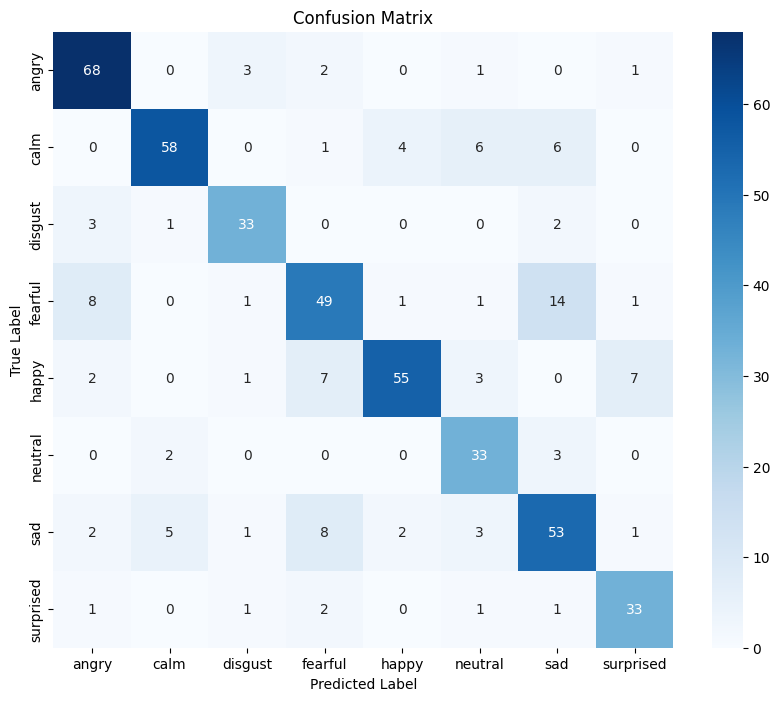

In [24]:
# Step 8: Evaluate
def evaluate_model(model, val_loader, le, device=device):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            _, preds = torch.max(outputs, 1)
            y_true.extend(y_batch.numpy())
            y_pred.extend(preds.cpu().numpy())
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    f1 = f1_score(y_true, y_pred, average='weighted') * 100
    accuracy = accuracy_score(y_true, y_pred) * 100
    cm = confusion_matrix(y_true, y_pred)
    
    print(f"Confusion matrix shape: {cm.shape}")
    print(f"LabelEncoder classes: {le.classes_}")
    print(f"Validation label distribution: {np.bincount(y_true, minlength=len(le.classes_))}")
    print(f"Predicted label distribution: {np.bincount(y_pred, minlength=len(le.classes_))}")
    print("Per-class F1 scores:")
    class_f1 = f1_score(y_true, y_pred, average=None) * 100
    for idx, emotion in enumerate(le.classes_):
        print(f"{emotion}: {class_f1[idx]:.2f}%")
    
    class_accuracies = np.zeros(len(le.classes_))
    cm_diag = cm.diagonal()
    cm_sums = cm.sum(axis=1)
    for i in range(min(cm.shape[0], len(le.classes_))):
        if cm_sums[i] > 0:
            class_accuracies[i] = cm_diag[i] / cm_sums[i] * 100
    
    print(f"Weighted F1 Score: {f1:.2f}%")
    print(f"Overall Accuracy: {accuracy:.2f}%")
    print("Class-wise Accuracies:")
    for idx, emotion in enumerate(le.classes_):
        print(f"{emotion}: {class_accuracies[idx]:.2f}%")
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

evaluate_model(model, val_loader, le)

# Save model
torch.save(model.state_dict(), '/kaggle/working/emotion_classification_model.pth')